## Imports

In [14]:
import numpy as np
import madmom as mm
import librosa as lr
import librosa.display as display
import pretty_midi as pm
import matplotlib.pyplot as plt
import copy

## Constants

In [15]:
# DATAPOINT = "../datasets/maps/CH/" + \
#             "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
# MIDI_DATAPOINT = "../datasets/maps/CH/" + \
#         "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
    
DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
            "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.wav"
MIDI_DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
            "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.mid"

## Preprocess Datapoint

#### Generate spect:

In [16]:
log_filt = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fps=100, # 31.25 trash
    fmin=27.5,
    fmax=8000.0, # 2325 for 144 bins. 8000 for 229 bins
    fref=440.0,
    circular_shift=False,
    hop_size=441.0)

In [17]:
log_filt.shape

(303, 229)

In [18]:
log_filt = lr.util.normalize(log_filt)

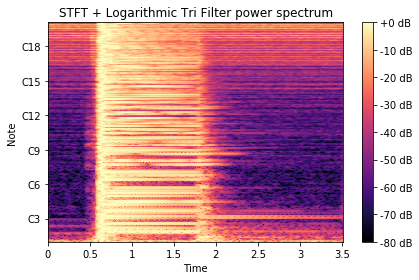

In [19]:
lr.display.specshow(
    lr.amplitude_to_db(log_filt, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Generate ground truths:

In [20]:
times = lr.frames_to_time(
    np.arange(log_filt.shape[0]),
    sr=44100,
    hop_length=441.0)
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [21]:
times[1]

0.01

In [22]:
yFrom = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
yFrom[yFrom > 0] = 0.35

In [23]:
def generate_midi_onsets(midi, pad_space):
    midi_onsets = copy.deepcopy(midi)
    
    # Modify notes to be all onsets within 50ms (0.05 seconds)
    for note in midi_onsets.instruments[0].notes:
        temp = note.start
        note.start = temp - pad_space
        note.end = temp + pad_space
    
    return midi_onsets


def generate_midi_offsets(midi, pad_space):
    midi_offsets = copy.deepcopy(midi)
    
    # Modify notes to be all offsets within 50ms (0.05 seconds)
    for note in midi_offsets.instruments[0].notes:
        temp = note.end
        note.start = note.end - pad_space
        note.end = temp + pad_space
    
    return midi_offsets

# sample = midi.instruments[0].notes[0]
# print sample
# new_note = sample
# temp = new_note.start
# new_note.end = temp
# new_note.start = new_note.end - 0.1
# print new_note

In [24]:
midi.instruments[0].notes

[Note(start=0.518994, end=1.515986, pitch=51, velocity=62),
 Note(start=0.518994, end=1.515986, pitch=52, velocity=95),
 Note(start=0.519987, end=1.516991, pitch=54, velocity=35),
 Note(start=0.519987, end=1.519982, pitch=55, velocity=77),
 Note(start=0.521985, end=1.519982, pitch=59, velocity=60)]

In [25]:
offsets = generate_midi_offsets(midi, times[1])
offsets.instruments[0].notes

[Note(start=1.505986, end=1.525986, pitch=51, velocity=62),
 Note(start=1.505986, end=1.525986, pitch=52, velocity=95),
 Note(start=1.506991, end=1.526991, pitch=54, velocity=35),
 Note(start=1.509982, end=1.529982, pitch=55, velocity=77),
 Note(start=1.509982, end=1.529982, pitch=59, velocity=60)]

In [26]:
onsets = generate_midi_onsets(midi, times[1])
onsets.instruments[0].notes

[Note(start=0.508994, end=0.528994, pitch=51, velocity=62),
 Note(start=0.508994, end=0.528994, pitch=52, velocity=95),
 Note(start=0.509987, end=0.529987, pitch=54, velocity=35),
 Note(start=0.509987, end=0.529987, pitch=55, velocity=77),
 Note(start=0.511985, end=0.531985, pitch=59, velocity=60)]

In [27]:
midi_onsets = generate_midi_onsets(midi, times[1])
yOn = midi_onsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOn[yOn > 0] = 0.5

In [28]:
midi_offsets = generate_midi_offsets(midi, times[1])
yOff = midi_offsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOff[yOff > 0] = 0.2

In [29]:
mask = (yOn == 0)
combined = np.copy(yOn)
combined[mask] = yOff[mask]

In [30]:
mask = (combined == 0)
combined = np.copy(combined)
combined[mask] = yFrom[mask]

## Visualize Datapoint with Ground Truths

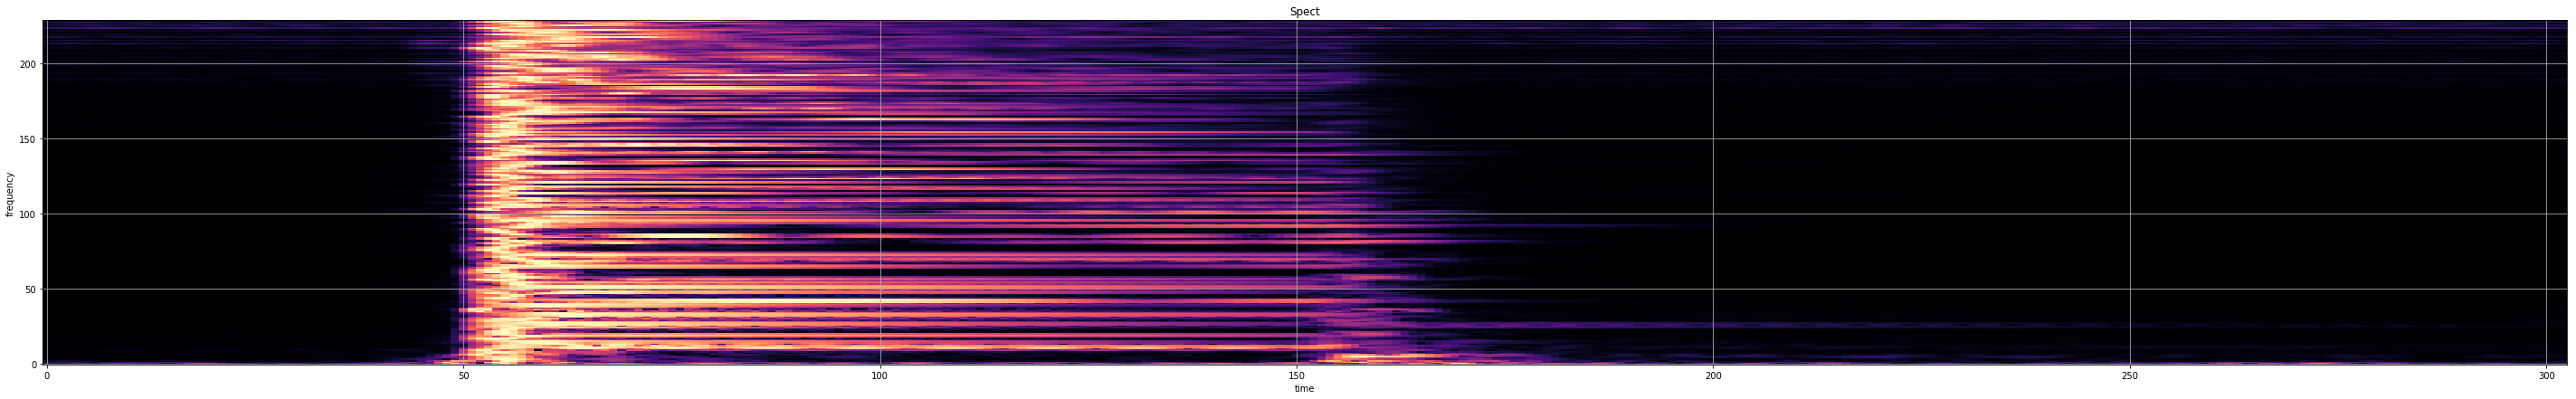

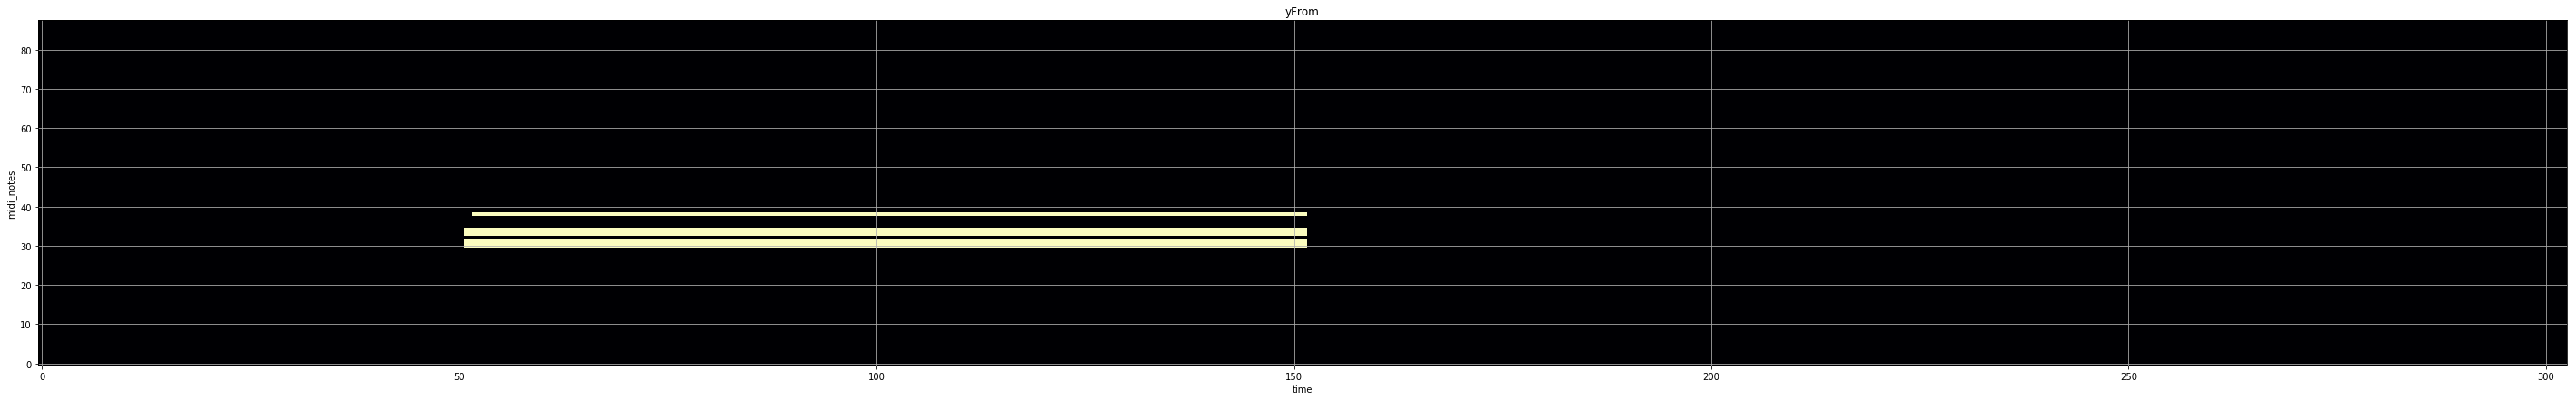

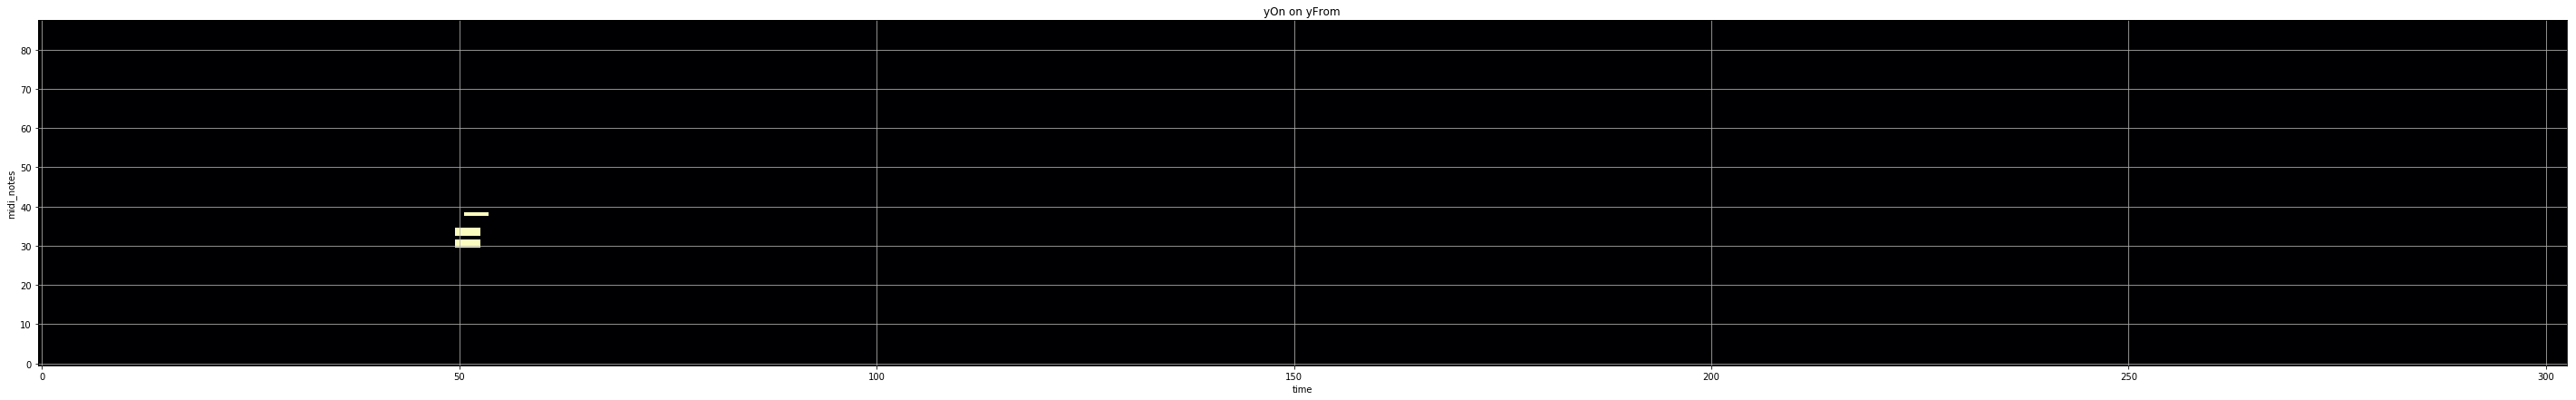

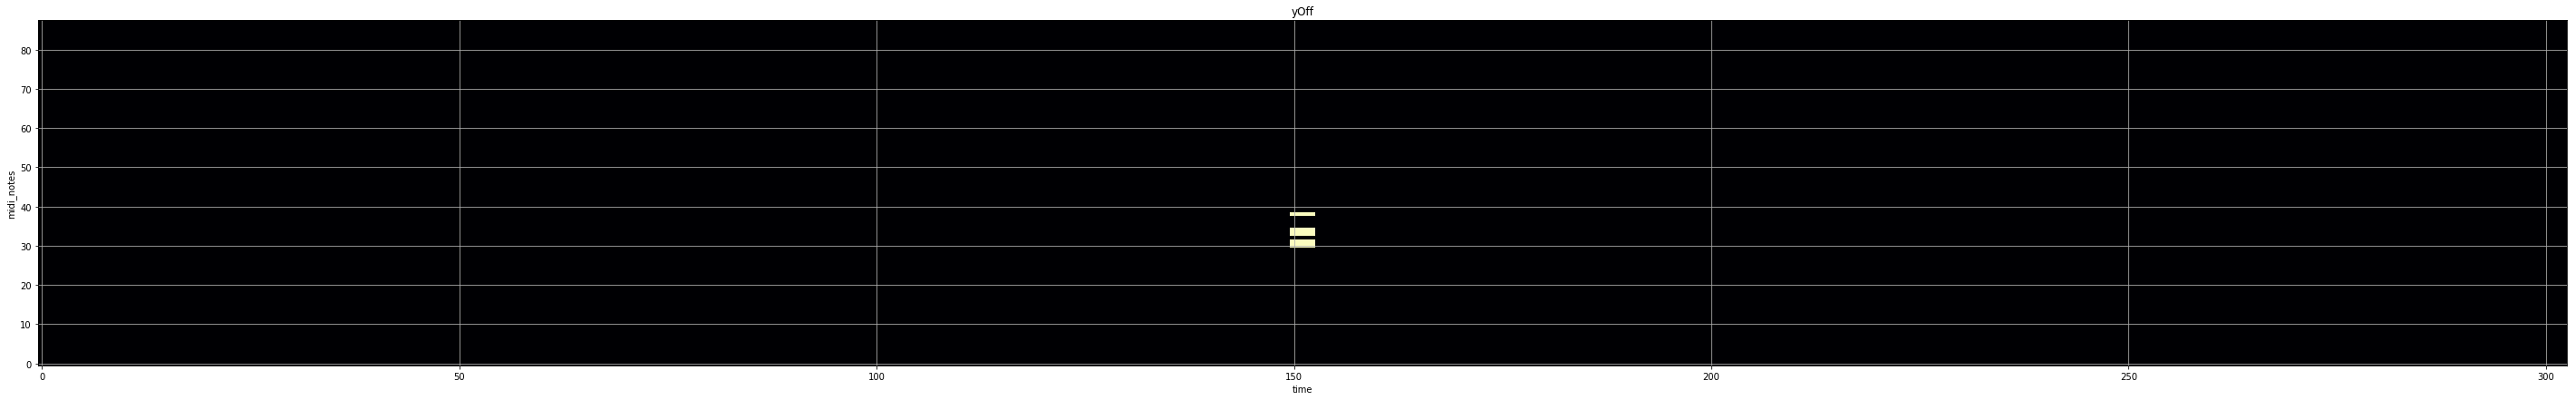

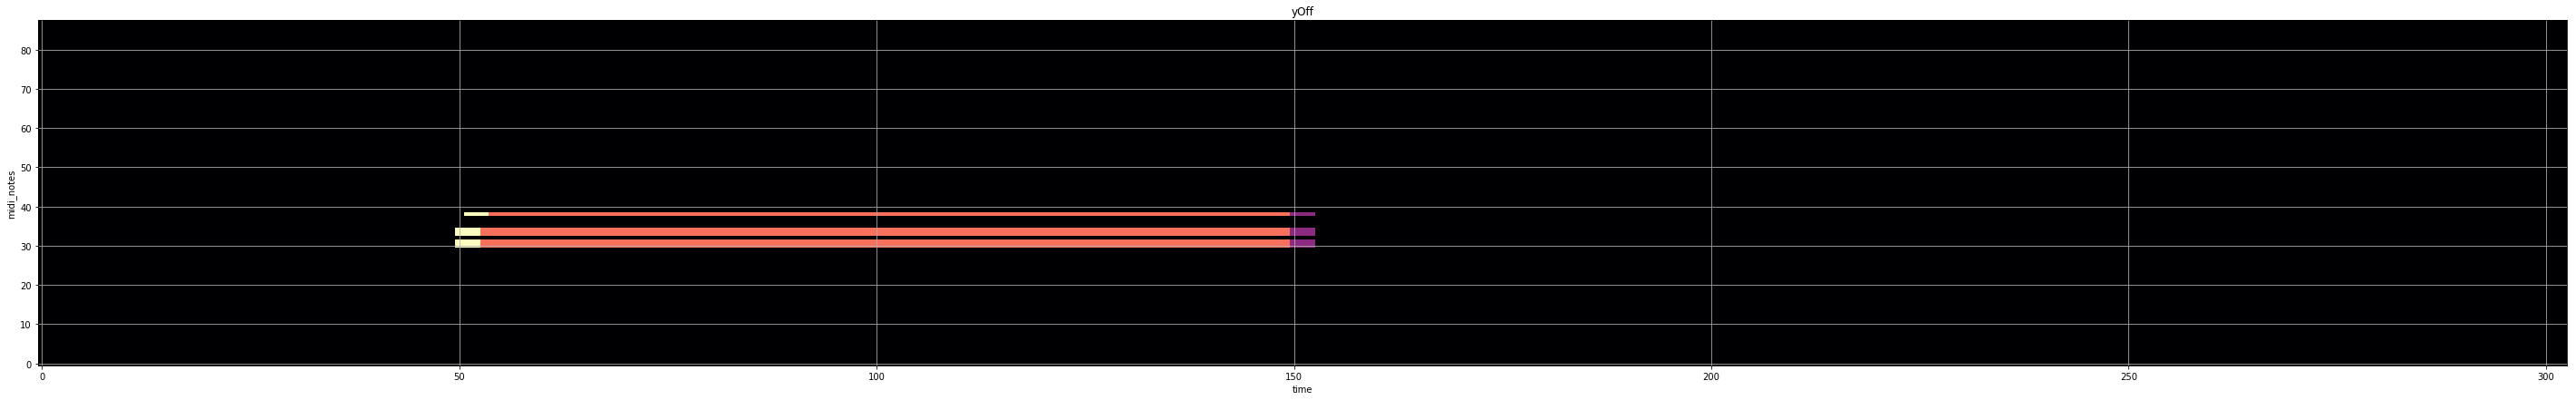

In [34]:
length = 50

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(log_filt.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.title("Spect")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yFrom.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yFrom")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yOn.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOn on yFrom")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yOff.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOff")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(combined.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOff")
plt.show()